In [1]:
#%matplotlib notebook
 
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const


### This tutorial demonstrates cross-correlation functions

*(This notebook uses the model template generated from the A1_SimpleTransmisionSpectrum which should be in the same directory you are running the notebook from.)*

Cross-correlation functions (CCFs) are fundamnetal to high-resolution time-series spectroscopy of exoplanets. This tutorial goes through a few different ways of performing CCFs with numpy. We will use the model tranmission spectrum created before as our template model.

See [the wikipedia article](https://en.wikipedia.org/wiki/Cross-correlation) for mathematical details. The CCF is used to match functions. The basic idea is that you 'slide' one function over another, each time multiplying the two togehter and summing. The cross-correlation function is therefore a function of the lag, and the maximum of the CCF occurs when the two functions overlap the most.

In exoplanet observations, we use the CCF to match observations with atmospheric model templates. Individual lines in transmission spectra are often to weak to be seen directly, using CCFs allows us to boost the signal by summing over many spectral lines.

First, how to use np.correlate to get auto/cross-correlation functions:


Text(0, 0.5, 'ccf')

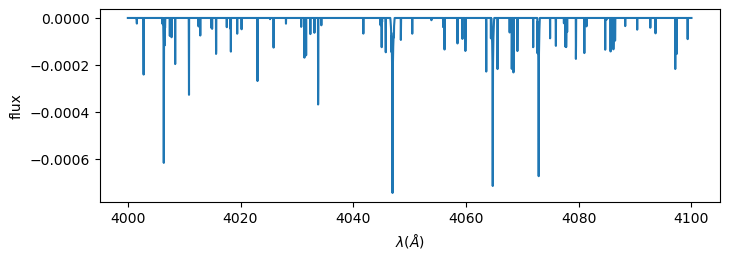

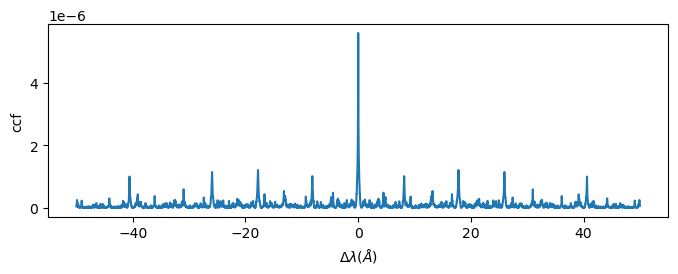

In [2]:
#get the model transmission spectrum from before
wl_template,template = np.load('model_FeI_2500K.npy')

#first we will interpolate the model to a new wavelength scale
wl = np.linspace(4000,4000+100,4000)
signal = np.interp(wl,wl_template,template)

#make a plot: the signal consists of some spectra lines with continuum at zero
plt.figure(figsize=(8,2.5))
plt.plot(wl,signal)
plt.xlabel(r'$\lambda (\AA)$')
plt.ylabel('flux')

#the first thing we can try is taking the cross-correlation of the signal with itself
# this is the auto-correlation function
# here this will be a function of delta wavelength
# note that the peak is at zero, as this is where the functions overlap
# also note that there are multiple other peaks - these are aliased signals where two strong lines overlap
#   but not the whole template. These types of aliasing peaks could result in a false positive
#   but they can be distinguished from real peaks based partly on the wavelength/velocity lag
#   in addition, the more lines we have, the weaker they become relative to the main peak
cc = np.correlate(signal,signal,'same')
plt.figure(figsize=(8,2.5))
plt.plot(wl-wl.mean(),cc)
plt.xlabel(r'$\Delta\lambda (\AA)$')
plt.ylabel('ccf')



A more realistic scenario is where we have some noisy data, and we want to find if a signal is buried within the noise.


Text(0, 0.5, 'ccf')

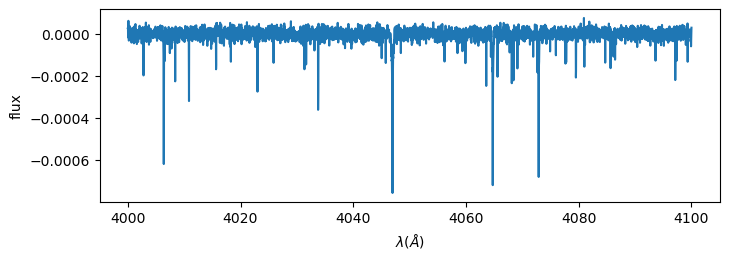

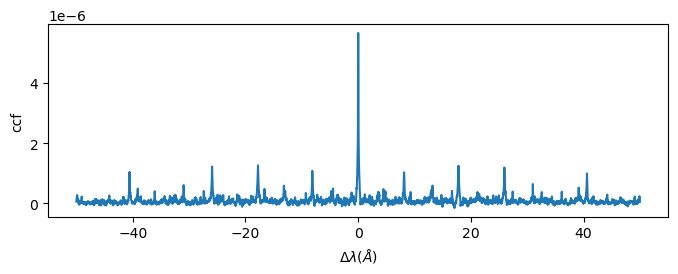

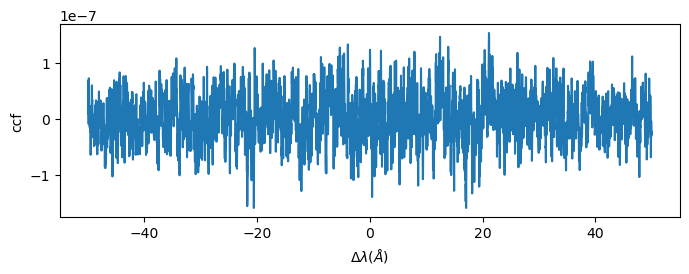

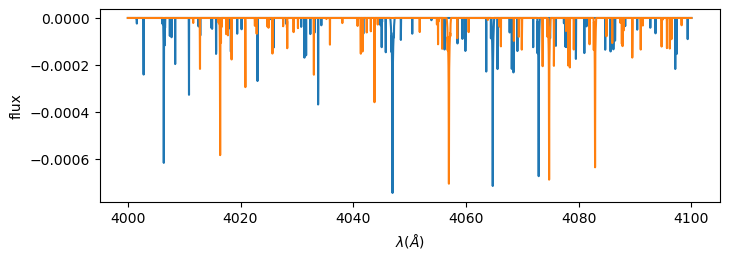

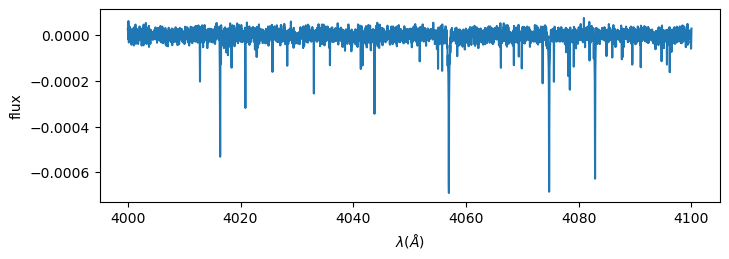

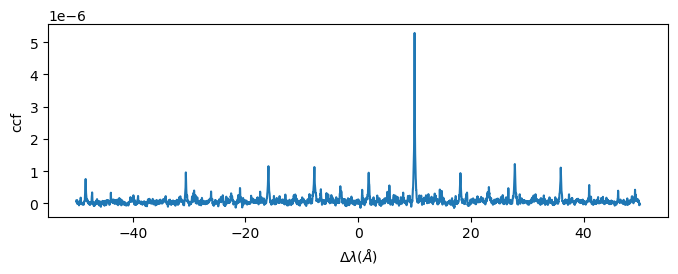

In [3]:

#create some noise, and add in signal
noise = np.random.normal(0,0.00002,signal.size)
flux = noise + signal

#make a plot = note that we cannot see the signal due to the noise
plt.figure(figsize=(8,2.5))
plt.plot(wl,flux)
plt.xlabel(r'$\lambda (\AA)$')
plt.ylabel('flux')

#take the cross-correlation and plot
# note that we get a strong peak above the noise, and can therefore conclude that the template is hidden in the data
# without being able to 'see' the template itself!
# This is exactly how we can recover faint signals from exoplanet atmospheres!
cc = np.correlate(flux,signal,'same')
plt.figure(figsize=(8,2.5))
plt.plot(wl-wl.mean(),cc)
plt.xlabel(r'$\Delta\lambda (\AA)$')
plt.ylabel('ccf')

#if we instead to the same with just the noise, note we don't get any peak at zero - just more noise
cc = np.correlate(noise,signal,'same')
plt.figure(figsize=(8,2.5))
plt.plot(wl-wl.mean(),cc)
plt.xlabel(r'$\Delta\lambda (\AA)$')
plt.ylabel('ccf')

#we can also shift the signal to the right by interpolation
shifted_signal = np.interp(wl-10,wl,signal)
plt.figure(figsize=(8,2.5))
plt.plot(wl,signal)
plt.plot(wl,shifted_signal)
plt.xlabel(r'$\lambda (\AA)$')
plt.ylabel('flux')
plt.figure(figsize=(8,2.5))
plt.plot(wl,shifted_signal+noise)
plt.xlabel(r'$\lambda (\AA)$')
plt.ylabel('flux')

#taking the cross-correlation, the peak is now shifted to the right, as expected
cc = np.correlate(shifted_signal+noise,signal,'same')
plt.figure(figsize=(8,2.5))
plt.plot(wl-wl.mean(),cc)
plt.xlabel(r'$\Delta\lambda (\AA)$')
plt.ylabel('ccf')



The cross-correaltion function, as implemented by numpy, has an important limitation. Each lag that the CCF is computed for is a linear shift of 1 pixel. In the case of astronomical spectra however, we are dealing with Doppler shifts, which are not linear shifts in wavelength. Therefore it is useful to write out own cross-correlation function to have more control. There are a number of ways to do this.


Text(0, 0.5, 'ccf')

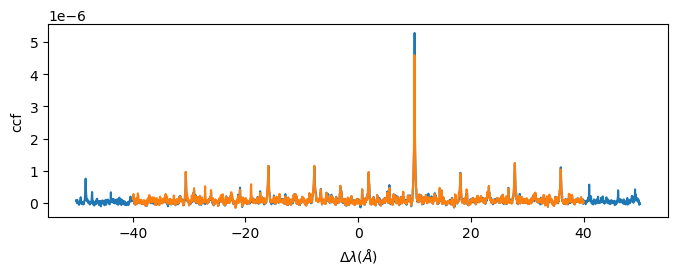

In [4]:
#define our test dataset
shifted_signal = np.interp(wl-10,wl,signal)
flux = shifted_signal+noise

#define a set of lags to compute the cross-correlation function over
lags = np.linspace(-40,40,2000)
ccf = np.empty(lags.size) #create empty array to store the result

#loop over the lags, and compute CCF
for i,l in enumerate(lags):
  shifted_template = np.interp(wl-l,wl_template,template)
  ccf[i] = np.sum(shifted_template * flux)

#compare to numpy version - note there might be a small difference in scale due to how the interpolation is done
plt.figure(figsize=(8,2.5))
plt.plot(wl-wl.mean(),np.correlate(flux,signal,'same'))
plt.plot(lags,ccf)
plt.xlabel(r'$\Delta\lambda (\AA)$')
plt.ylabel('ccf')


Another option is to pre-compute all of the shifted templates first as a 2D array. This is more efficient, and allows the shifted spectra to be reused.

Text(0, 0.5, 'ccf')

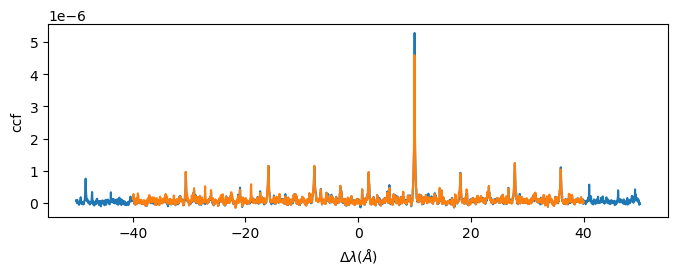

In [5]:

#The new axis command is very useful for creating 2D arrays by summing/subtracting 1D arrays
W = wl[np.newaxis,:] - lags[:,np.newaxis] #create a 2D array of wavelength shifts for each lag
shifted_templates = np.interp(W,wl_template,template) #note that interpolate can work with a multi-dimensional array as first arg
ccf = np.sum(shifted_templates * flux,axis=1) #multiply the flux with each shifted template and sum
ccf = np.dot(shifted_templates,flux) #or do the same thing with matrix product - usually more efficient

#compare to numpy version - note there might be a small difference in scale due to how the interpolation is done
plt.figure(figsize=(8,2.5))
plt.plot(wl-wl.mean(),np.correlate(flux,signal,'same'))
plt.plot(lags,ccf)
plt.xlabel(r'$\Delta\lambda (\AA)$')
plt.ylabel('ccf')
